Import required packages

In [2]:
import pandas as pd
print("Pandas " + pd.__version__)
import seaborn as sns
print("Seaborn " + sns.__version__)

import matplotlib.pyplot as plt    #Plotting library used by seaborn, see http://matplotlib.org/users/pyplot_tutorial.html
%matplotlib inline

import statsmodels.api as sm

import rasterio
from rasterio.plot import show

from osgeo import gdal

import numpy as np
np.set_printoptions(precision=3)

import os
import math
import copy

Pandas 0.25.1
Seaborn 0.9.0


Load data into memory from csv file

In [3]:
LOI200 = pd.read_csv("LOI200.csv")

Check data

In [4]:
LOI200.head()

,Site,logDD,DistanceLC,NewDBH,NewBA,SnowDepth,LCProp,Ecoregion,AspenProp,HdwdProp,LCProp.1,CountStands
0,2,1.72,0.158,19.9,19.3,238,0.09,1,0.0,0.77,0.09,5
1,3,1.01,0.301,26.8,13.8,223,0.00,1,0.0,1.00,0.00,1
2,4,0.98,0.240,29.5,19.0,163,0.00,1,0.0,1.00,0.00,1
3,5,1.24,0.250,28.5,14.0,176,0.00,1,0.0,1.00,0.00,1
4,6,1.08,0.121,25.6,18.1,152,0.08,1,0.0,0.92,0.08,5


In [5]:
LOI200.describe()

,Site,logDD,DistanceLC,NewDBH,NewBA,SnowDepth,LCProp,Ecoregion,AspenProp,HdwdProp,LCProp.1,CountStands
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1840.686275,1.149804,0.285392,24.323529,21.296078,248.411765,0.037843,2.000000,0.123529,0.791373,0.037843,3.627451
std,1958.204478,0.362626,0.185569,4.864343,3.708798,56.621260,0.097597,1.216553,0.173687,0.220273,0.097597,2.097244
min,2.000000,0.330000,0.010000,13.800000,13.800000,152.000000,0.000000,1.000000,0.000000,0.190000,0.000000,1.000000
25%,29.500000,0.920000,0.163000,21.300000,18.600000,205.500000,0.000000,1.000000,0.000000,0.680000,0.000000,2.000000
50%,837.000000,1.170000,0.233000,24.900000,20.900000,233.000000,0.000000,1.000000,0.020000,0.850000,0.000000,3.000000
75%,4142.000000,1.395000,0.355500,27.150000,23.450000,299.000000,0.015000,3.000000,0.200000,0.985000,0.015000,5.000000
max,5342.000000,1.810000,0.930000,34.500000,29.200000,372.000000,0.460000,4.000000,0.720000,1.000000,0.460000,9.000000


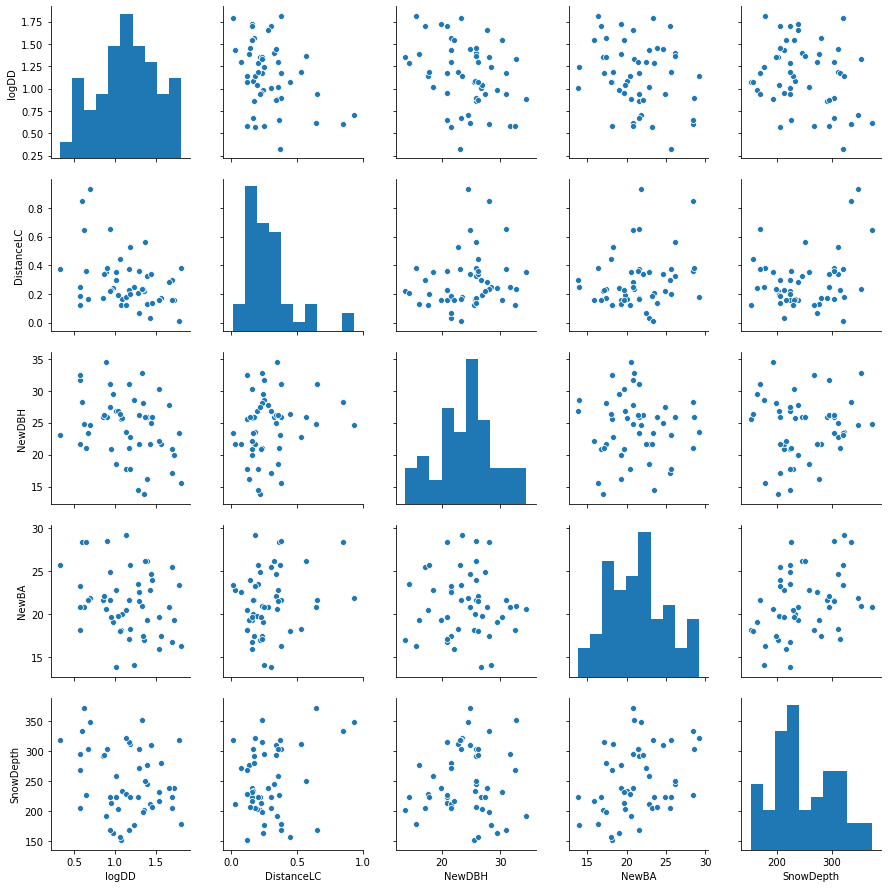

In [6]:
sns.pairplot(LOI200.loc[:,'logDD':'SnowDepth'])

## Section 3: Simple Linear Regression and Correlation
Now that we have familiarised ourselves with the data, the first piece of proper analysis we will do is to fit simple linear regression models to predict (log) deer density from environmental co-variates 

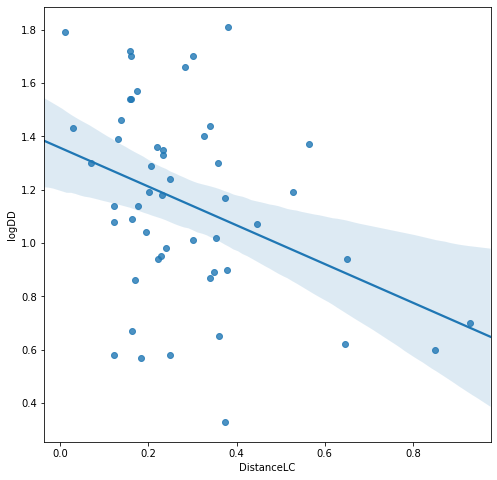

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=LOI200.DistanceLC, y=LOI200.logDD)

In python, linear regression can be performed using functions available in the `statsmodels` package. Read the docs and more detail [here](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html). Specifically we can use the `OLS` function from the `statsmodels.api`. 

Using the `OLS` function from `statsmodels` to fit a regression requires we create an `OLS` object first, then use the `fit` [method](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html) on that object to create a `RegressionResults` [object](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults). An easy way to create an `OLS` object is to use the `from_formula` [method](https://www.statsmodels.org/dev/dev/generated/statsmodels.base.model.Model.from_formula.html?highlight=from_formula#statsmodels.base.model.Model.from_formula) to pass the equation of the model we want to fit (as well as indicating what the data are that we are using):

In [8]:
mod_dlc = sm.OLS.from_formula("logDD ~ DistanceLC", data = LOI200) 
mod_dlc_RR = mod_dlc.fit()

What happened...? Well, it looks like nothing happened but we have indeed now fit a regression model!

To check this we we should look at a summary of the model (by using the `summary` [method](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.summary.html?highlight=summary#statsmodels.regression.linear_model.RegressionResults.summary) on the `RegressionResults` object we just created) to understand what the model can tell us:

In [9]:
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                  logDD   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     7.842
Date:                Fri, 29 May 2020   Prob (F-statistic):            0.00729
Time:                        09:30:35   Log-Likelihood:                -16.342
No. Observations:                  51   AIC:                             36.68
Df Residuals:                      49   BIC:                             40.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3569      0.088     15.424      0.0

We can also access specific properties of the `RegressionResults` object (see full list of properties [here](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html?highlight=regressionresults)):

In [11]:
round(mod_dlc_RR.rsquared,3)

0.138

Pearson correlation

In [12]:
corrmat_pearson = LOI200.corr()
round(corrmat_pearson.iloc[1:7,1:7],3)

,logDD,DistanceLC,NewDBH,NewBA,SnowDepth,LCProp
logDD,1.000,-0.371,-0.322,-0.247,-0.248,0.304
DistanceLC,-0.371,1.000,0.201,0.221,0.267,-0.433
NewDBH,-0.322,0.201,1.000,-0.027,0.026,-0.218
NewBA,-0.247,0.221,-0.027,1.000,0.332,0.012
SnowDepth,-0.248,0.267,0.026,0.332,1.000,0.012
LCProp,0.304,-0.433,-0.218,0.012,0.012,1.000


Kendall rank correlation

In [13]:
corrmat_kendall = LOI200.corr(method="kendall")
round(corrmat_kendall.iloc[1:7,1:7],3)

,logDD,DistanceLC,NewDBH,NewBA,SnowDepth,LCProp
logDD,1.000,-0.212,-0.222,-0.159,-0.107,0.164
DistanceLC,-0.212,1.000,0.151,0.143,0.070,-0.609
NewDBH,-0.222,0.151,1.000,-0.023,-0.014,-0.201
NewBA,-0.159,0.143,-0.023,1.000,0.235,-0.094
SnowDepth,-0.107,0.070,-0.014,0.235,1.000,-0.071
LCProp,0.164,-0.609,-0.201,-0.094,-0.071,1.000


### Task 1

The code in Section 3 provides all you need to calculate the values in the first row of Table 1 in Millington et al. (2010). 

**TASK:** Copy the code above and edit it below to calculate values for the four other  variables in Table 1 that have p < 0.1. Check you can get values from your code that correspond to those in Table 1 of Millington et al. (2010)

## Section 4
In Section 2 we did some simple plotting to visualise our data. Now we will do some more plotting to visualise the results of the models you have just fit. 

## Section 5. Multiple linear regression models. 
Fitting linear regression models with more than one are almost as straighforward as for simple (univariate) linear regression models.

In [14]:
mod_dlc_dbh = sm.OLS.from_formula("logDD ~ DistanceLC + NewDBH", data = LOI200) 
mod_dlc_dbh_RR = mod_dlc_dbh.fit()
print(mod_dlc_dbh_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                  logDD   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     6.071
Date:                Fri, 29 May 2020   Prob (F-statistic):            0.00446
Time:                        09:31:05   Log-Likelihood:                -14.377
No. Observations:                  51   AIC:                             34.75
Df Residuals:                      48   BIC:                             40.55
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7960      0.240      7.493      0.0

## Section 6. Cross-validation
To complete the bottom two lines of Table 2 in Millington et al. (2010) we need to run cross-validation. In python, we can use functionality from sklearn for [cross-validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6).

First, we need to fit the model again using `sklearn` to create a model object that it will be able handle:  

In [15]:
from sklearn import linear_model

#create independent and dependent variables
df_X = LOI200[['DistanceLC','NewDBH']]  
df_y = LOI200['logDD']                  

#fit the mode 
regr = linear_model.LinearRegression()
regr.fit(df_X, df_y)

#we can get simple otuputs
print(regr.coef_)  #model coefficients
print(regr.score(df_X, df_y)) #r2

[-0.624 -0.019]
0.20188714479823777


We can use the fitted model to estimate predicted values for all out observations:

In [16]:
Predicted = regr.predict(df_X)
print(Predicted)

[1.314 1.092 1.079 1.092 1.228 1.259 1.394 1.402 1.269 1.293 1.11  1.22
 0.722 0.742 1.027 1.248 1.198 1.157 0.914 1.252 1.114 1.362 1.192 1.39
 1.336 1.021 1.094 1.233 1.167 1.339 1.061 1.13  0.916 0.946 1.264 1.211
 1.279 1.269 1.087 0.966 1.031 1.105 1.119 1.08  1.379 1.244 1.011 0.794
 1.068 1.094 1.327]


To do a single 5-fold cross validation for the regression model we would use:

In [17]:
from sklearn import model_selection

cvpred = model_selection.cross_val_predict(regr, df_X, df_y, cv=5)

print(cvpred)

[1.218 1.071 1.084 1.087 1.19  1.122 1.236 1.267 1.192 1.208 1.1   1.27
 0.801 0.85  1.083 1.268 1.185 1.144 0.888 1.272 1.079 1.348 1.17  1.437
 1.327 0.97  1.091 1.226 1.195 1.313 1.064 1.127 0.885 0.921 1.252 1.21
 1.253 1.26  1.081 0.961 1.034 1.137 1.146 1.113 1.443 1.302 1.028 0.781
 1.098 1.158 1.38 ]


This has created an array of predicted values based on models fit for each of the folds created (see `model_selection.KFold` for [more](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=kfold#sklearn.model_selection.KFold) on how the folds are created). 

Now append the predictors (from both all observations and the cross-validation) to the original data to allow us to calculate correlations for comparing between using all observed data vs k-folds:

In [18]:
CVdata = LOI200
CVdata['Predicted'] = Predicted
CVdata['cvpred'] = cvpred

#Predicted
r = CVdata['logDD'].corr(CVdata['Predicted'])
r2 = r**2
t = CVdata['logDD'].corr(CVdata['Predicted'], method='kendall')
    
print("r2 (obs): ", round(r2,3))   
print("tau (obs): ", round(t,3))
print('\n')

#Cross Validated
r = CVdata['logDD'].corr(CVdata['cvpred'])
r2 = r**2
t = CVdata['logDD'].corr(CVdata['cvpred'], method='kendall')
    
print("r2 (cv): ", round(r2,3))   
print("tau (cv): ", round(t,3))

r2 (obs):  0.202
tau (obs):  0.311


r2 (cv):  0.089
tau (cv):  0.181


But note how the caption of Table 2 indicates that 
>"estimates for cross-validation results are 95% confidence intervals calculated from mean and variance of 100 repetitions." 

To do this we need to create a loop to run the cross-validation multiple times, storing the results so we can calculate the mean
and variance:

In [19]:
cv_r2 = []
cv_tau = []

for i in range(100):

    kf = model_selection.KFold(n_splits=5,shuffle=True, random_state=i)  #needed to create random folds (using i)
    cvpred = model_selection.cross_val_predict(regr, df_X, df_y, cv=kf)  #predict using current random folds
    
    #correlations
    r = LOI200['logDD'].corr(pd.Series(cvpred))
    tau = LOI200['logDD'].corr(pd.Series(cvpred), method='kendall')
    
    #append to list
    cv_r2.append(r**2)
    cv_tau.append(tau)
  

Now we can calculate mean and variance for r2 and tau

In [29]:
print(np.mean(cv_r2))
print(np.mean(cv_tau))
print(1.96 * np.var(cv_r2))  
print(1.96 * np.var(cv_tau))

#printoptions precision does not work for numpy.float64! 
#see https://stackoverflow.com/questions/47637972/numpy-set-printoptions-precision-ignored-in-list-of-tuples

0.11282454846579286
0.21431461453916778
0.0018006481871323046
0.0026672948598997956


### TASK 4
Use the code in Section 6 to calculate the cross-validation values for the 'Full' model

## Section 7 Spatial Estimation
Later in Millington et al. (2010) models fit from the sample data (at 51 locations) were used to predict deer density across a subsection of the study area. We can do this in python using the functionality in the `rasterio` [package](https://rasterio.readthedocs.io/).

Well... can we? The rasterio package doesn't have predict methods like for R and [others have simply suggested using R](https://stackoverflow.com/questions/48853484/how-to-structure-data-for-prediction-using-rasters-as-targets) Maybe use pyimpute? https://github.com/perrygeo/pyimpute This has some nice features and contains a lot of the functionality we want, _but_ it assumes the data used to fit models are from the study rasters themselves (indicated by points within the raster). In the current situation, we have already fit the model using point data and now simply want to apply the fitted model parameters to our explanatory rasters. So we can use some the nice code from pyimput t  

Alternatively, use np arrays with np predict methods: see [here](https://stackoverflow.com/questions/29036179/what-is-the-python-equivalent-to-r-predict-function-for-linear-models) and [here](https://www.statsmodels.org/devel/examples/notebooks/generated/predict.html)

How then how to do that for a multi-band raster (i.e., 3D array)? 

Is this useful? https://geohackweek.github.io/raster/

Also https://github.com/nextgis/molusce


**Solution: used masked arrays**

Useful links:

- https://numpy.org/doc/stable/reference/maskedarray.generic.html
- https://stackoverflow.com/a/38856546
- https://stackoverflow.com/a/38194439


First, we need to create a ndarray containing the point predictor 

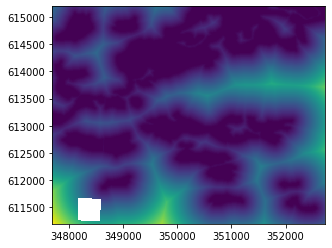

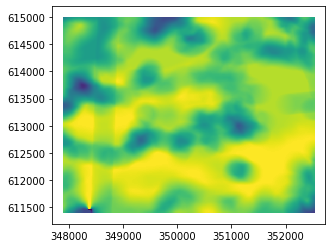

In [32]:
dlc_r = rasterio.open('LOI200_dlc_km.asc')
rasterio.plot.show(dlc_r)

dbh_r = rasterio.open('LOI200_Meandbh_cm.asc')
rasterio.plot.show(dbh_r)

Try this first with a single raster

In [198]:
with rasterio.open('LOI200_dlc_km.asc') as src:
    dlc_r = src.read(1)  # TODO band num?
        
dlc_f = dlc_r.flatten()

print(type(dlc_f))
print(dlc_f.shape)

<class 'numpy.ndarray'>
(202104,)


In [199]:
#create the mask

import numpy.ma as ma
ma_dlc = ma.masked_values(dlc_f, -9999)
ma_dlc.view(ma.MaskedArray)


masked_array(data=[0.42399999499320984, 0.41600000858306885,
                   0.40799999237060547, ..., 0.3140000104904175,
                   0.3199999928474426, --],
             mask=[False, False, False, ..., False, False,  True],
       fill_value=-9999.0,
            dtype=float32)

In [81]:
#remove ND values for prediction

mac_dlc = ma.compressed(ma_dlc)
#print(mac_dlc.shape)
mac_dlc.view()

array([0.424, 0.416, 0.408, ..., 0.308, 0.314, 0.320], dtype=float32)

In [203]:
#fit the regression and predict on 1D data
#create independent and dependent variables
df_X = LOI200['DistanceLC']
df_y = LOI200['logDD']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the mode 
uniregr = linear_model.LinearRegression()
uniregr.fit(new_df_X, df_y)

res = uniregr.predict(dlc_f.reshape(-1,1))

res = res.astype(np.float32) #original were float32

In [204]:
#invert the data back to original positions in 1D using mask
#this approach to invert the mask from https://stackoverflow.com/a/38856546 
#pred_dlc = np.empty_like(ma_dlc)
#pred_dlc.view(ma.MaskedArray)

#np.place(pred_dlc,pred_dlc.mask,-9999)
#np.place(pred_dlc,~pred_dlc.mask,res)



pred_dlc = ma.MaskedArray(res, mask=ma_dlc.mask,fill_value=-9999)

pred_dlc

masked_array(data=[1.0491999387741089, 1.055006504058838,
                   1.060813069343567, ..., 1.1290398836135864,
                   1.1246849298477173, --],
             mask=[False, False, False, ..., False, False,  True],
       fill_value=-9999.0,
            dtype=float32)

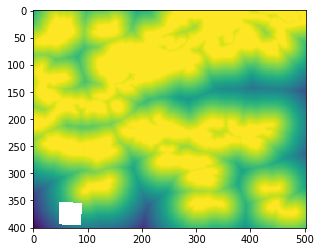

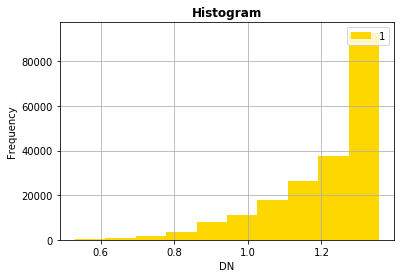

In [205]:
#reshape back to 2D

pred2D = pred_dlc.reshape(dlc_r.shape)

rasterio.plot.show(pred2D)
rasterio.plot.show_hist(pred2D)

Now try with multi-variate model

In [164]:
#make this a loop later
with rasterio.open('LOI200_dlc_km.asc') as src:
    dlc_r = src.read(1)  # TODO band num?
        
dlc_f = dlc_r.flatten()


with rasterio.open('LOI200_Meandbh_cm.asc') as src:
    dbh_r = src.read(1)  # TODO band num?
        
dbh_f = dbh_r.flatten()

joint_f = [dlc_f,dbh_f]
joint_f = np.array(joint_f).T


[[    0.424 -9999.000]
 [    0.416 -9999.000]
 [    0.408 -9999.000]
 ...
 [    0.314 -9999.000]
 [    0.320 -9999.000]
 [-9999.000 -9999.000]]


In [214]:
#create the mask

#proof of concept for multiple arrays
'''
ND = -9999
a = np.array([1,2,3,ND])
b = np.array([ND,2,3,4])

ama = ma.masked_values(a,ND)
bma = ma.masked_values(b,ND)
  
c = bma
print(c)
c = ma.masked_where(ama.mask | bma.mask,d)

print(c)
'''

ND = -9999

ma_dlc = ma.masked_values(dlc_f,ND)
ma_dbh = ma.masked_values(dbh_f,ND)

ma_joint = ma_dbh
ma_joint = ma.masked_where(ma_dlc.mask | ma_dbh.mask, ma_joint)
#len(ma_joint)


ma_joint2 = ma_dbh
ma_joint2 = ma.masked_where(ma_dlc.mask, ma_joint2)
ma_joint2 = ma.masked_where(ma_dbh.mask, ma_joint2)



print(ma_joint.view())
print(ma_joint2.view())
(ma_joint == ma_joint2).all()


[-- -- -- ... -- -- --]
[-- -- -- ... -- -- --]


True

In [215]:
#fit the regression and predict on 1D data
#create independent and dependent variables

#create independent and dependent variables
df_X = LOI200[['DistanceLC','NewDBH']]  
df_y = LOI200['logDD']                  

#fit the mode 
regr = linear_model.LinearRegression()
regr.fit(df_X, df_y)

mres = regr.predict(joint_f)  #can't predict on compressed data (irregular missing values between variables), just use original 

mres = mres.astype(np.float32) #original were float32

print(mres)
len(mres)


[ 193.941  193.946  193.951 ...  194.010  194.006 6436.188]


202104

In [216]:
#create a mask array from the values in mres and the mask in ma_joint, filling no data with -9999
ma_mres = ma.MaskedArray(mres, mask=ma_joint2.mask,fill_value=-9999)


(401, 504)


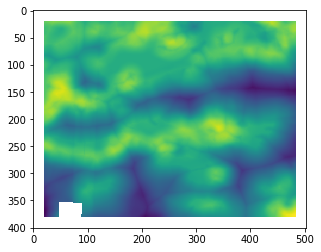

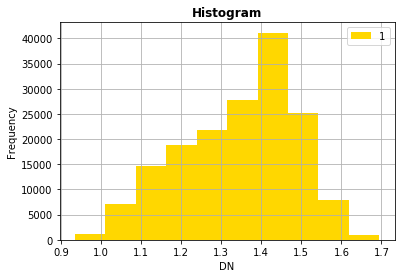

In [217]:
print(dlc_r.shape)
responses2D = ma_mres.reshape(dlc_r.shape)

rasterio.plot.show(responses2D)
rasterio.plot.show_hist(responses2D)


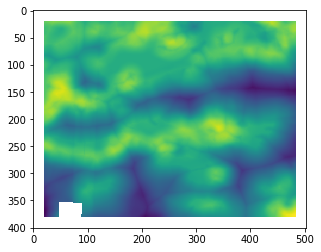

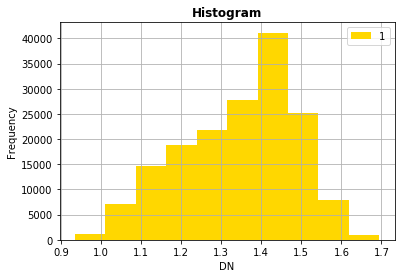

In [230]:
explanatory_rasters = ['LOI200_dlc_km.asc', 'LOI200_Meandbh_cm.asc'] 
er_arrays = []
rshape = None

#loop reading rasters 
for idx, raster in enumerate(explanatory_rasters):
    with rasterio.open(raster) as src:
        er = src.read(1)  
    
    #use shape of first raster for later plotting (assumes all raster have same extent)
    if(idx == 0):
        rshape = er.shape
    
    #convert from 2D to 1D then append to list of arrays
    arf = er.flatten()
    er_arrays.append(arf)

expl = np.array(er_arrays).T  #convert list of arrays to numpy array and transpose 

ND = -9999
mask_arrays = []

#loop list of raster data (1D) to create individual mask arrays 
for er in er_arrays:
    mask_er = ma.masked_values(er,ND)
    mask_arrays.append(mask_er)

#create base mask for combined mask of all rasters   
mask_array = mask_arrays[0]

#loop individual mask arrays incrementally adding masking to get combined mask
for mar in mask_arrays:
    mask_array = ma.masked_where(mar.mask, mask_array)

#fit the regression on the orinigal data     
pred = regr.predict(expl)  #can't predict on compressed data (irregular missing values between variables), just use original 
pred = pred.astype(np.float32) #original were float32

#now mark output from prediction using the mask of all rasters
mask_pred = ma.MaskedArray(pred, mask=mask_array.mask,fill_value=-9999)

#go back from 1D to 2D using first raster shape
pred2D = mask_pred.reshape(rshape)

#finally plot!
rasterio.plot.show(pred2D)
rasterio.plot.show_hist(pred2D)



In [228]:

len(mask_array)

202104

In [33]:
#load_targets works pretty well


def load_targets(explanatory_rasters):
    """
    Parameters
    ----------
    explanatory_rasters : List of Paths to GDAL rasters containing explanatory variables
    Returns
    -------
    expl : Array of explanatory variables
    raster_info : dict of raster info
    """

    explanatory_raster_arrays = []
    aff = None
    shape = None
    crs = None

    for raster in explanatory_rasters:
        #logger.debug(raster)
        with rasterio.open(raster) as src:
            ar = src.read(1)  # TODO band num? 

            # Save or check the geotransform
            if not aff:
                aff = src.transform
            else:
                assert aff == src.transform

            # Save or check the shape
            if not shape:
                shape = ar.shape
            else:
                assert shape == ar.shape

            # Save or check the geotransform
            if not crs:
                crs = src.crs
            else:
                assert crs == src.crs

        # Flatten in one dimension
        arf = ar.flatten()
        explanatory_raster_arrays.append(arf)

    expl = np.array(explanatory_raster_arrays).T

    raster_info = {
        'affine': aff,
        'shape': shape,
        'crs': crs
    }
    return expl, raster_info

explanatory_rasters = ['LOI200_dlc_km.asc', 'LOI200_Meandbh_cm.asc']

target_xs, raster_info = load_targets(explanatory_rasters)


In [21]:
#trying to understand the data type produced (3d array?)
print(type(target_xs))
print(len(target_xs))
print(target_xs.shape)

#Not 3d array, seems to lose second dimension... this is because it is flattened in load_targets! 
#(see comment "Flatten in one dimension")

test = copy.copy(target_xs[12000:12003])
print(test)

test[1] = np.nan
print(test)

#sklearn does not seem to like working with missing data - next line is error
#dum = regr.predict(test)
#print(dum)

<class 'numpy.ndarray'>
202104
(202104, 2)
[[ 0.1    16.7474]
 [ 0.1    16.4403]
 [ 0.1    16.1331]]
[[ 0.1    16.7474]
 [    nan     nan]
 [ 0.1    16.1331]]


Use numpy 'masked array' to handle 'no data' values. i.e. use `numpy.ma`. Proof of concept: 

In [31]:
import numpy.ma as ma
x = np.array([1, 2, 3, -1, 5])
mx = ma.masked_array(x, mask=[0, 0, 0, 1, 0])

print(x.mean())
print(mx.mean())

2.0
2.75


In [22]:
#editing pyimpute function to work with continuous regression AND output masked arrays

def impute(target_xs, regr, raster_info, outdir="output", linechunk=1000, class_prob=False, certainty=False):
    """
    Parameters
    ----------
    target_xs: Array of explanatory variables for which to predict responses
    clf: instance of a scikit-learn Classifier
    raster_info: dictionary of raster attributes with key 'gt', 'shape' and 'srs'
    Options
    -------
    outdir : output directory
    linechunk : number of lines to process per pass; reduce only if memory is constrained
    class_prob : Boolean. Should we create a probability raster for each class?
    certainty : Boolean. Should we produce a raster of overall classification certainty?
    """
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    shape = raster_info['shape']

     
    # Chunky logic
    if not linechunk:
        linechunk = shape[0]
    chunks = int(math.ceil(shape[0] / float(linechunk)))

    for chunk in range(chunks):
        #logger.debug("Writing chunk %d of %d" % (chunk+1, chunks))
        row = chunk * linechunk
        if row + linechunk > shape[0]:
            linechunk = shape[0] - row
        # in 1D space
        start = shape[1] * row
        end = start + shape[1] * linechunk
        line = target_xs[start:end, :]

        window = ((row, row + linechunk), (0, shape[1]))

        # Predict
        responses = regr.predict(line)
        responses2D = responses.reshape((linechunk, shape[1]))
        
    return responses, responses2D

            
res, res2D = impute(target_xs, regr, raster_info)

#I think responses 2D has now been un-flattened! (back to 2D, but now only 1 variable)


<class 'numpy.ndarray'>
401
(401, 504)


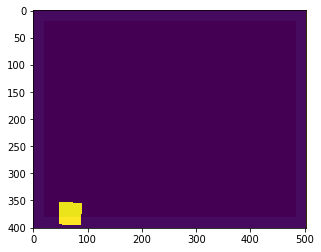

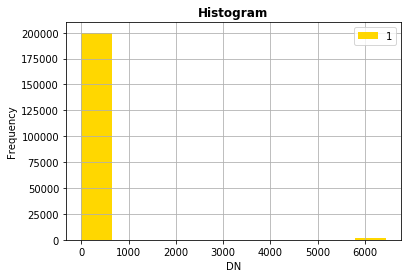

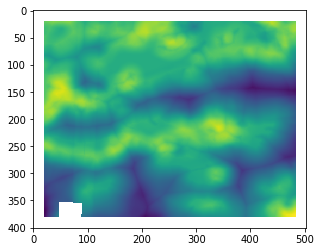

/home/james/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/james/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


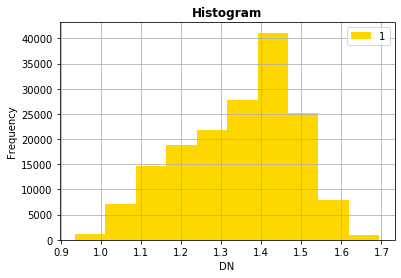

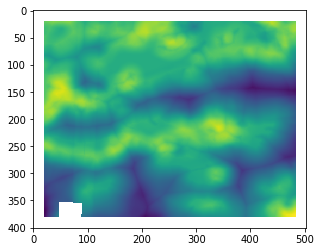

In [23]:
#more exploring output 


print(type(res2D))
print(len(res2D))
print(res2D.shape)


#no data pixels are being estimated
rasterio.plot.show(res2D)
rasterio.plot.show_hist(res2D)

#try to remove these
res2D_1k = copy.copy(res2D)
res2D_1k[res2D_1k>25] = np.nan

rasterio.plot.show(res2D_1k)
rasterio.plot.show_hist(res2D_1k)

#loss of border is due to extent of NewDBH (see above)
rasterio.plot.show(res2D_1k)

#error messages are because of introduced nan
#https://stackoverflow.com/questions/37651803/runtimewarning-invalid-value-encountered-in-greater

#sklearn and numpy do not seem to like working with missing data!


Other appraches. 

Also see https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/

In [24]:
#https://automating-gis-processes.github.io/2016/Lesson7-read-raster.html

#installing gdal too some effort: https://mothergeo-py.readthedocs.io/en/latest/development/how-to/gdal-ubuntu-pkg.html

raster = gdal.Open('LOI200_dlc_km.asc')
print(type(raster))
#rasterArray = dlc.ReadAsArray()  #error
#print(type(rasterArray))

<class 'osgeo.gdal.Dataset'>


In [25]:
# Projection
print("Projection= ", raster.GetProjection())

# Dimensions
print("NCols= ", raster.RasterXSize)
print("NRows= ", raster.RasterYSize)

# Number of bands
print("NBands= ", raster.RasterCount)

# Metadata for the raster dataset
print("MetaData= ", raster.GetMetadata())

Projection=  
NCols=  504
NRows=  401
NBands=  1
MetaData=  {}


In [26]:
# Read raster data as numeric array from GDAL Dataset
rasterArray = raster.ReadAsArray()
print(type(raster))
print(type(rasterArray))

<class 'osgeo.gdal.Dataset'>
<class 'numpy.ndarray'>
